In [1]:
%matplotlib inline
import numpy as np
#import tqdm.notebook as tqdm
#import matplotlib.pyplot as plt
import matplotlib.pylab as plt
plt.style.use('seaborn-white')

import matplotlib.gridspec as gridspec


plt.style.use('seaborn-white')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('axes', labelsize=20)
plt.rc('font', family='serif')
plt.rc('font', family='serif')
plt.rcParams['image.cmap'] = 'Spectral'

In [2]:
from scipy.integrate import odeint

from jointly_smooth_functions import JointlySmoothFunctions
import datafold.pcfold as pfold
import datafold.dynfold as dfold

from sklearn.preprocessing import StandardScaler

import warnings
from scipy.sparse import SparseEfficiencyWarning
warnings.simplefilter('ignore',SparseEfficiencyWarning)

## Subsystem Two

In [3]:
def midlevel_MEK_ERK_model2(x, t, k4, k5, k6):
    """
    Evaluate time-derivatives of the six concentrations in Yeung et al.'s kinetic model.
    """
    dS1  =  -k4*x[0]*x[3] +k5*x[1]
    dES1 =  k4*x[0]*x[3] - k5*x[1] - k6*x[1]
    dS2  =  k6*x[1]
    dE   = -k4*x[0]*x[3]+ k5*x[1]  + k6*x[1]
    
    return [dS1,dES1, dS2, dE]

In [4]:
use_S2_only = False
generator = np.random.RandomState(12345)

num_samples = 2000
num_steps = 20
E0 = 0.66 # initial concentration of enzyme
C0 = np.array([5.0, 0.0, 0.0, E0]) # initial concentrations of S0, ES0, ES1, S1, S2, E
time_points = np.linspace(0, 12.5, num_steps + 1)
delta_k = 0.2 # relative half-width of rate constant perturbations
rate_constants = np.zeros((num_samples, C0.size-1))
observations = np.zeros((num_samples, (1 if use_S2_only else 4)*num_steps)) # data to be used for DMaps
# Integrate the ODE for various (randomly perturbed) parameter values:
base_kvals = np.array([0.97, 7000 ,10000])
for i in range(num_samples):
    kvals = base_kvals*generator.uniform(low = 1.0 - delta_k, high = 1.0 + delta_k, size = C0.size -1)
    sol = odeint(midlevel_MEK_ERK_model2, C0, time_points, args = tuple(kvals))
    
    # Store rate constant values and observed concentrations:
    rate_constants[i,:] = kvals
    if use_S2_only:
        observations[i,:] = sol[1:,2]
    else:
        observations[i,:] = sol[1:,:].reshape(1,-1)
        
k_eff = rate_constants[:,0]*rate_constants[:,2]/(rate_constants[:,2]+rate_constants[:,1])

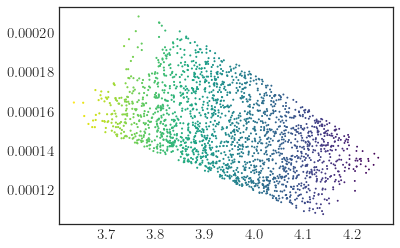

In [5]:
fig,ax = plt.subplots(1,1,)
ax.scatter(*observations[:,:3].T, c=k_eff, cmap="viridis")

Observations is the matrix in which the output/behaviors are being saved (its a matrix with the rows being the different data points/experiments and the rows the saved outputs.

The way the code runs right now produces 2000 samples and saves all 4 chemical species by changing the use_S2_only to True you will save only one of the chemical species.

In [6]:
observations_file = "example2_data.txt"
np.savetxt(observations_file, observations)
parameters_file = "example2_parameters.txt"
np.savetxt(parameters_file, rate_constants)


In [7]:
rate_constants_scaled = StandardScaler().fit_transform(rate_constants)
observations_scaled = StandardScaler(with_std=False).fit_transform(observations)

# s1 = observations
# s2 = rate_constants

s1 = observations_scaled
s2 = rate_constants_scaled

# now try to compute jointly smooth functions on the two data sets.

We also scramble half of the columns of the observations.

In [8]:
n_kernel_evecs = 250
n_common_evecs = 25

cknn_k_neighbor = 50
cknn_delta = 1

kernel_tolerance = 1e-9
eigenvector_tolerance = 1e-8

rng = np.random.default_rng(1)
s1_scrambled = s1.copy()
s1_remove = s1[:, :s1.shape[1]//2]
s1_scrambled[:, :s1.shape[1]//2] = rng.uniform(low=np.min(s1_remove,axis=0),
                                              high=np.max(s1_remove, axis=0),
                                              size=(s1.shape[0], s1.shape[1]//2))

print("s1 low", np.min(s1_remove,axis=0))
print("s1 high", np.max(s1_remove,axis=0))

kernel = pfold.kernels.ContinuousNNKernel(k_neighbor=cknn_k_neighbor, delta=cknn_delta)

jsf = JointlySmoothFunctions(n_kernel_evecs, n_common_evecs, kernel=None, kernel_eigenvalue_cut_off=kernel_tolerance, 
                             eigenvector_tolerance=eigenvector_tolerance,optimizer_result_scaling=3, backend='scipy.kdtree')
jsf.fit(np.column_stack([s1_scrambled, s2]), ending_points=[s1.shape[1], s1.shape[1]+s2.shape[1]])

s1 low [-3.20854925e-01 -4.24937997e-05 -2.97113458e-01 -5.82753941e-05
 -4.90198793e-01 -2.94133227e-05 -4.84610000e-01 -3.84395064e-05
 -5.62279504e-01 -2.02533035e-05 -5.93314251e-01 -2.54011431e-05
 -5.73913082e-01 -1.38948767e-05 -6.46232749e-01 -1.78565802e-05
 -5.49777492e-01 -1.44630087e-05 -6.60425729e-01 -1.48482161e-05
 -5.06154305e-01 -1.40397251e-05 -6.48460400e-01 -1.47076279e-05
 -4.53561015e-01 -1.31038292e-05 -6.19519268e-01 -1.48522270e-05
 -3.98594675e-01 -1.18663713e-05 -5.80243787e-01 -1.46210090e-05
 -3.45216484e-01 -1.05162287e-05 -5.35375624e-01 -1.39906375e-05
 -2.95641514e-01 -9.21051378e-06 -4.88243051e-01 -1.31704556e-05]
s1 high [2.97127186e-01 5.82753941e-05 3.20840522e-01 4.24937997e-05
 4.84612547e-01 3.84395064e-05 4.90197712e-01 2.94133227e-05
 5.93309301e-01 2.54011431e-05 5.62286227e-01 2.02533035e-05
 6.46222989e-01 1.78565801e-05 5.73923976e-01 1.38948767e-05
 6.60413095e-01 1.48482161e-05 5.49790222e-01 1.44630087e-05
 6.48446271e-01 1.47076279e-0

JointlySmoothFunctions(eigenvector_tolerance=1e-08,
                       kernel_eigenvalue_cut_off=1e-09,
                       n_jointly_smooth_functions=25, n_kernel_eigenvectors=250,
                       optimizer_result_scaling=3)

17.099341603617717
42.09934160361774


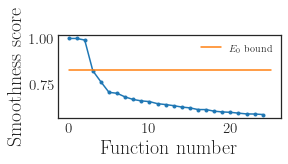

In [9]:

_e0 = jsf.calculate_E0()

fig, ax = plt.subplots(1,1,figsize=(4,2))
ax.plot(jsf.eigenvalues,'.-')
ax.plot([0, len(jsf.eigenvalues)], [_e0, _e0], label=r"$E_0$ bound")
ax.set_xlabel("Function number")
ax.set_ylabel("Smoothness score")
ax.legend()
print(jsf.eigenvalues.sum())
print(jsf.calculate_truncated_energies().sum())

fig.tight_layout()
fig.savefig("jsf_example2_score.pdf")
fig.savefig("jsf_example2_score.png")

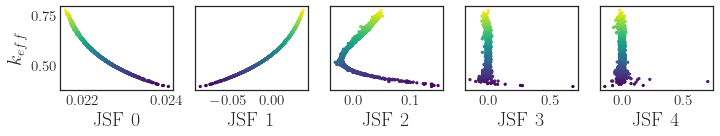

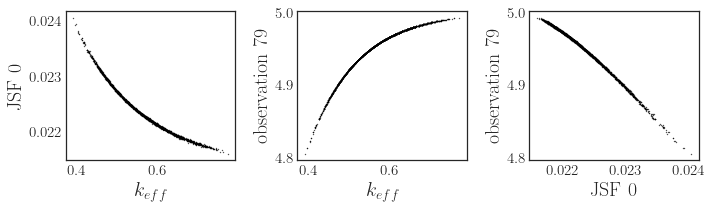

In [10]:
# plot the JSF over the effective parameter

idx_plot = np.arange(observations.shape[0])
map_to_observation = observations[:,-2]

use_smooth_function = jsf.jointly_smooth_functions[idx_plot, 0]

n_plots = 5
m_s = 5
cmap2 = "viridis"
fig,ax=plt.subplots(1,n_plots,figsize=(n_plots*2.,2), sharey=True)
for k in range(len(ax)):
    ax[k].scatter(jsf.jointly_smooth_functions[idx_plot,k],k_eff[idx_plot,].ravel(), c=k_eff[idx_plot], s=5, cmap=cmap2)
    # ax[k].set_xlabel(r"jointly smooth function")
    ax[k].set_xlabel(f"JSF {k}")
    if k==0:
        ax[k].set_ylabel(r"$k_{eff}$")

fig.tight_layout()


fig,ax=plt.subplots(1,3,figsize=(10.,3), sharey=False)
ax[2].scatter(use_smooth_function, map_to_observation, c="black", s=.1, cmap=cmap2)
ax[2].set_xlabel(f"JSF 0")
ax[2].set_ylabel(r"observation 79")
ax[1].set_ylabel(r"observation 79")
ax[1].scatter(k_eff, map_to_observation, c="black", s=.1, cmap=cmap2)
ax[1].set_xlabel(r"$k_{eff}$")

#fig.tight_layout()

#fig.savefig("jsf_example2_functionslast.pdf")
#fig.savefig("jsf_example2_functionslast.png")

#fig,ax=plt.subplots(1,1,figsize=(2.5,2), sharey=True)
ax[0].scatter(k_eff, use_smooth_function, c="black", s=.1, cmap=cmap2)
ax[0].set_ylabel(f"JSF 0")
ax[0].set_xlabel(r"$k_{eff}$")

fig.tight_layout()


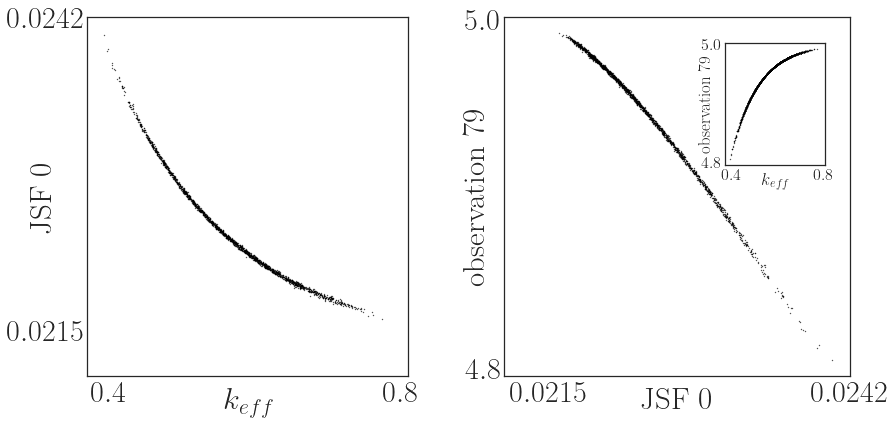

In [11]:
plt.rc('xtick', labelsize=30)
plt.rc('ytick', labelsize=30)
plt.rc('axes', labelsize=31)

fig2  = plt.figure(constrained_layout = False, figsize=(12,6))

spec2 = gridspec.GridSpec(nrows=14,ncols = 32, figure =fig2)
f2_ax1 = fig2.add_subplot(spec2[0:14,0:14])
f2_ax1.scatter(k_eff, use_smooth_function, c="black", s=.1, cmap=cmap2)
f2_ax1.set_ylabel(f"JSF 0")
f2_ax1.set_xlabel(r"$k_{eff}$")
f2_ax1.set_xlim([0.37,0.81])
f2_ax1.set_ylim([0.0211,0.0242])
f2_ax1.set_xticks([0.40,0.80])
f2_ax1.set_yticks([0.0215,0.0242])
f2_ax1.xaxis.labelpad=-20
f2_ax1.yaxis.labelpad=-50
plt.tight_layout()

f2_ax2 = fig2.add_subplot(spec2[0:14,17:])
f2_ax2.scatter(use_smooth_function, map_to_observation, c="black", s=.1, cmap=cmap2)
f2_ax2.set_xlabel(f"JSF 0")
f2_ax2.set_ylabel(r"observation 79")
f2_ax2.set_xlim([0.0211,0.0242])
f2_ax2.set_xticks([0.0215,0.0242])
f2_ax2.xaxis.labelpad=-20
f2_ax2.set_yticks([4.8,5])
f2_ax2.yaxis.labelpad=-25



plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('axes', labelsize=17)

f2_ax3 = fig2.add_subplot(spec2[1:6,26:31])
f2_ax3.set_ylabel(r"observation 79")
f2_ax3.scatter(k_eff, map_to_observation, c="black", s=.1, cmap=cmap2)
f2_ax3.set_xlabel(r"$k_{eff}$")
f2_ax3.xaxis.labelpad = -10
f2_ax3.set_yticks([4.8,5])
f2_ax3.yaxis.labelpad=-12
f2_ax3.set_xlim([0.37,0.81])
f2_ax3.set_xticks([0.40,0.80])
